<a href="https://colab.research.google.com/github/tsubauaaa/AITrialTraining/blob/main/Training4/AITraining4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
 # Google Driveをマウントする
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import json
import pandas as pd
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger') 

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [3]:
decoder = json.JSONDecoder()
all_datasets_list = []
all_datasets_sum_list = []
with open('/content/drive/My Drive/Colab Notebooks/AITraining/dataset_en_dev.json') as f:
    line = f.readline()
    while line:
        all_datasets_list.append(decoder.raw_decode(line)[0])
        line = f.readline()
with open('/content/drive/My Drive/Colab Notebooks/AITraining/test_preds_seq2seq.txt') as f:
    line = f.readline()
    while line:
        all_datasets_sum_list.append(line)
        line = f.readline()

In [4]:
print(all_datasets_list[1])
print(all_datasets_sum_list[1])
print(len(all_datasets_list))
print(len(all_datasets_sum_list))

{'review_id': 'en_0830781', 'product_id': 'product_en_0004522', 'reviewer_id': 'reviewer_en_0731158', 'stars': '1', 'review_body': "Shoes were purchased on March 6, 2019. My wife wore them a couple times a week since receiving them. April 19, 2019 one of the leather straps broke. Checked return policy and it expired on April 6. One month of warranty? Won't buy shoes from Amazon again.", 'review_title': 'Garbage!', 'language': 'en', 'product_category': 'shoes'}
My wife and I bought a pair of shoes from Amazon, and one of the straps broke.

5000
5000


In [5]:
datasets_list = []
for data, sum in zip(all_datasets_list, all_datasets_sum_list):
    review_body = data['review_body']
    stars = int(data['stars'])
    eval = 'H' if stars >=4 else 'L'
    product_category = data['product_category']
    datasets_list.append([product_category, review_body, sum, stars, eval])
datasets = pd.DataFrame(datasets_list, columns = ['product_category', 'review_body' , 'summary', 'stars', 'eval'])
datasets

,product_category,review_body,summary,stars,eval
0,baby_product,Pathetic design of the caps. Very impractical ...,We have been using these bottles for a few mon...,1,L
1,shoes,"Shoes were purchased on March 6, 2019. My wife...",My wife and I bought a pair of shoes from Amaz...,1,L
2,office_product,It's taken me 1 whole year to set this thing u...,It's been a long time since I've used a Canon ...,1,L
3,office_product,Each cartridge printed once. Both dried up in ...,I bought two 3D printer cartridges from a sell...,1,L
4,baby_product,No light hard to see,"All photographs courtesy of AFP, EPA, Getty Im...",1,L
...,...,...,...,...,...
4995,home,This ribbon is so adorable! Goes perfect with ...,I've been having so much fun making my own Chr...,5,H
4996,kitchen,I am in love with this kettle.,This is the kettle I've been using to make my ...,5,H
4997,pet_products,My Doberman Loves Having His Nails Trimmed and...,My Doberman Loves Having His Nails Trimmed and...,5,H
4998,other,"I love my Fire.. I do everything on it, read, ...",I have a Kindle Fire tablet that I have been u...,5,H


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:30: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


The length of the personal_care_appliances data was 0 and skipped.


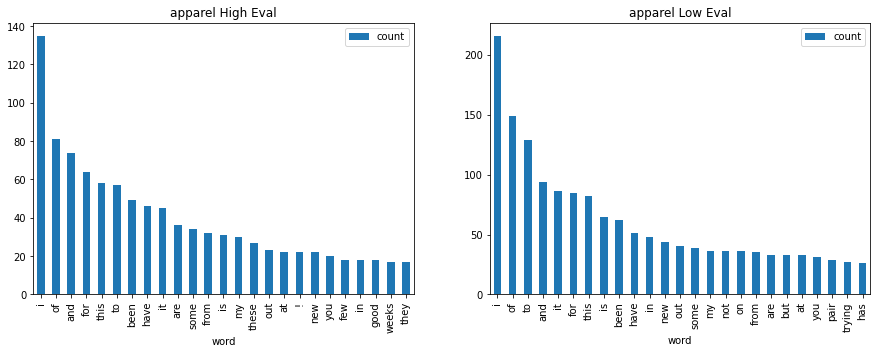

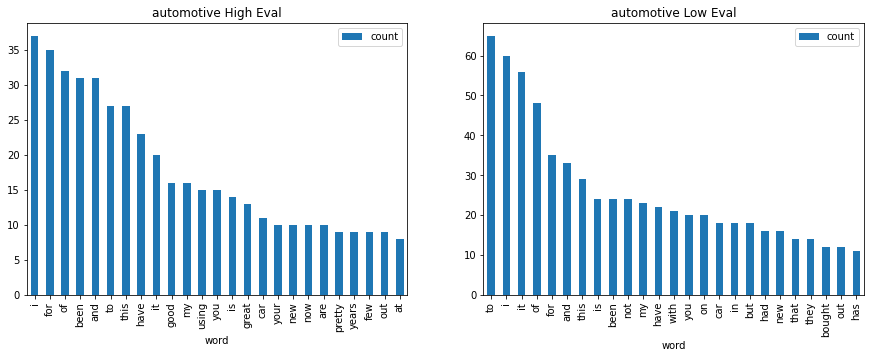

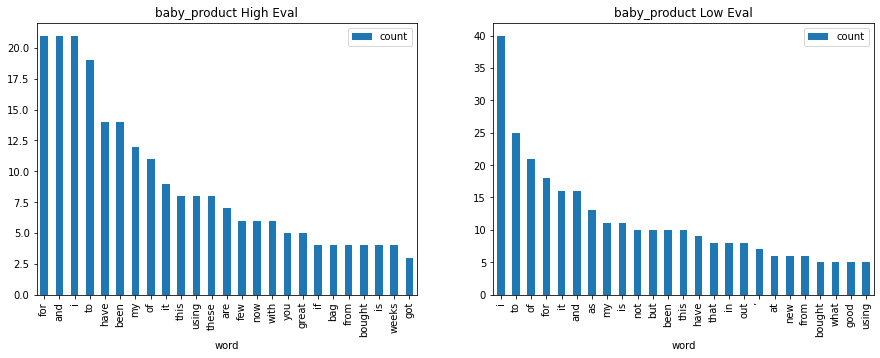

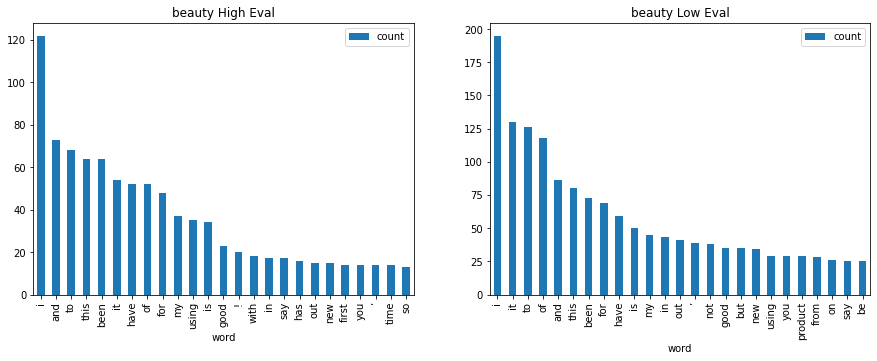

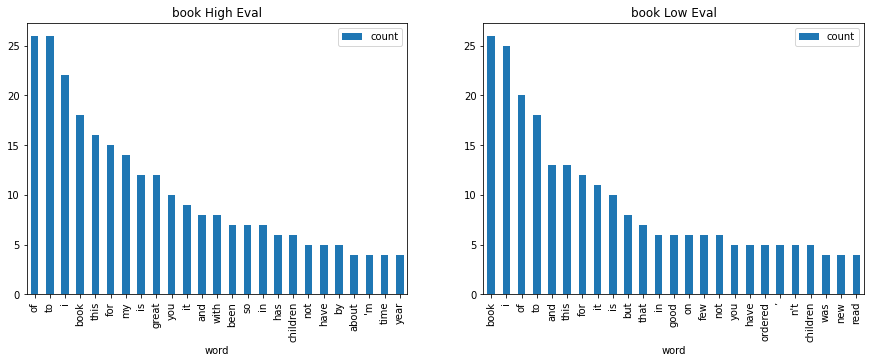

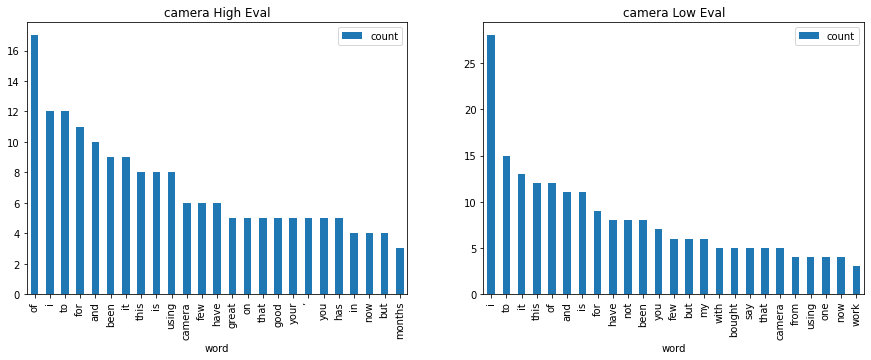

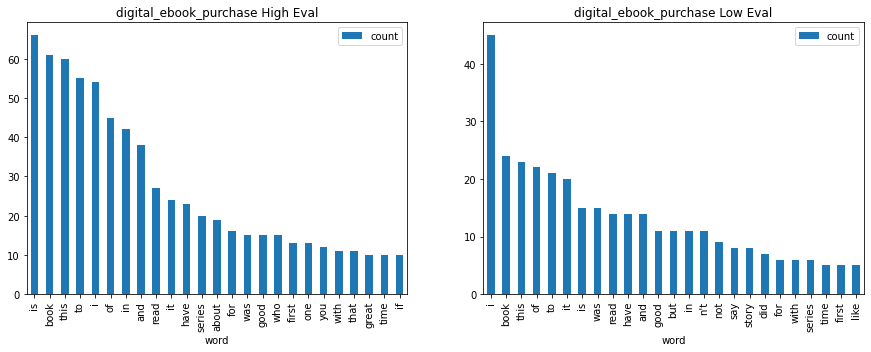

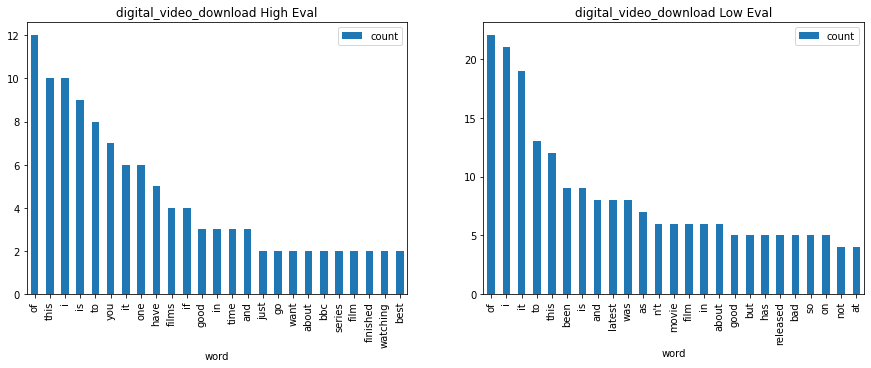

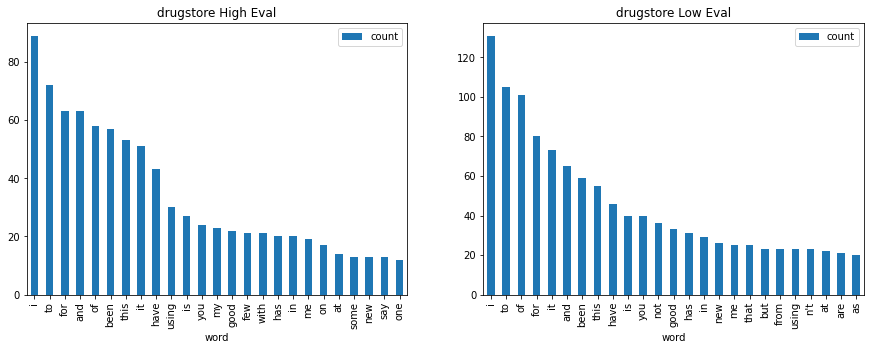

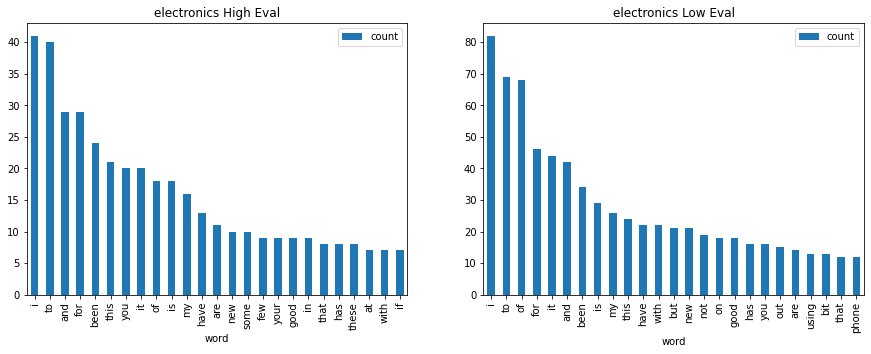

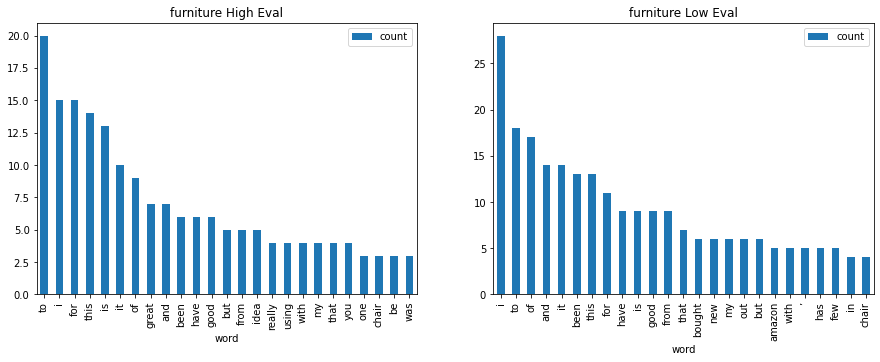

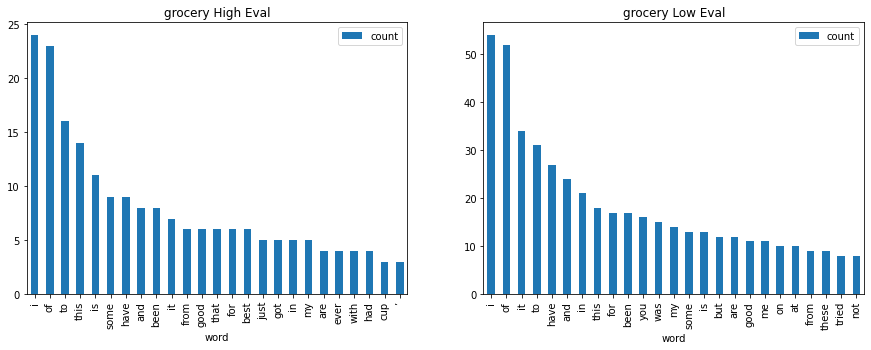

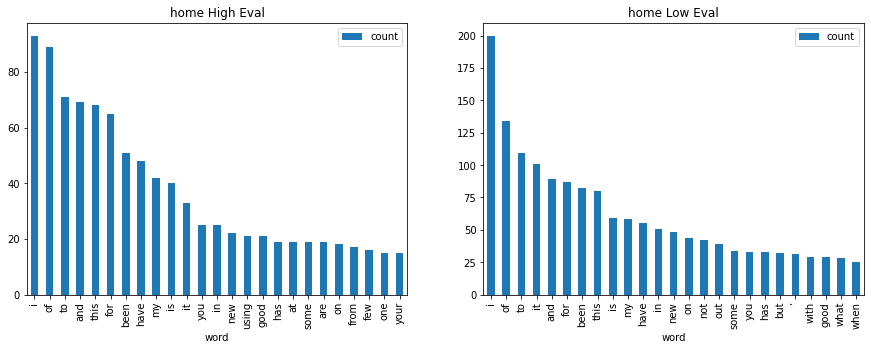

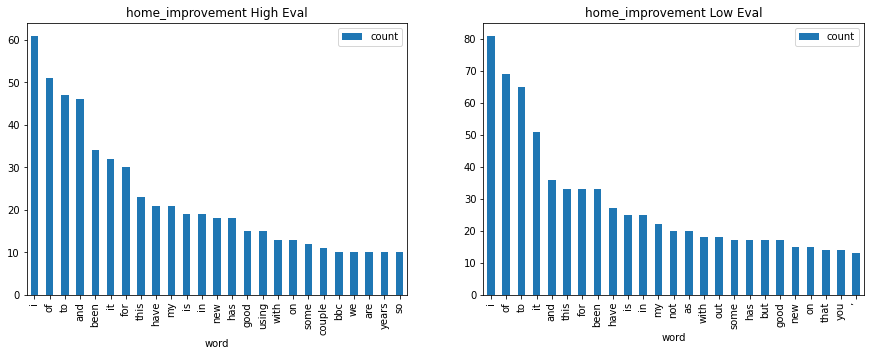

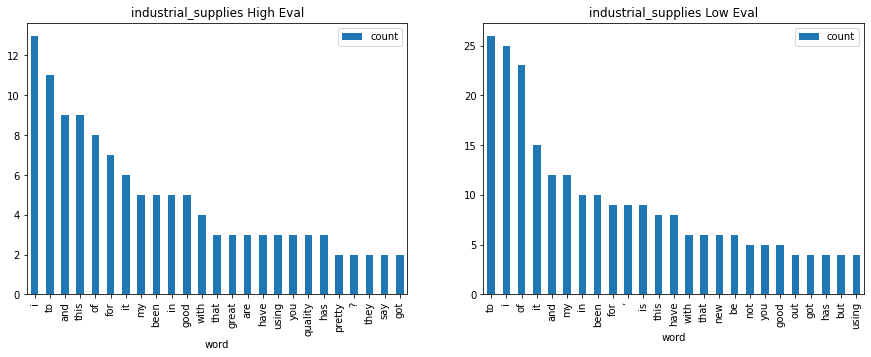

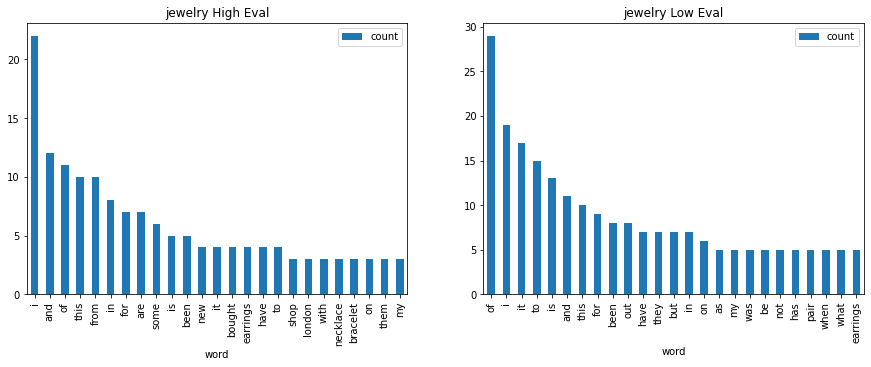

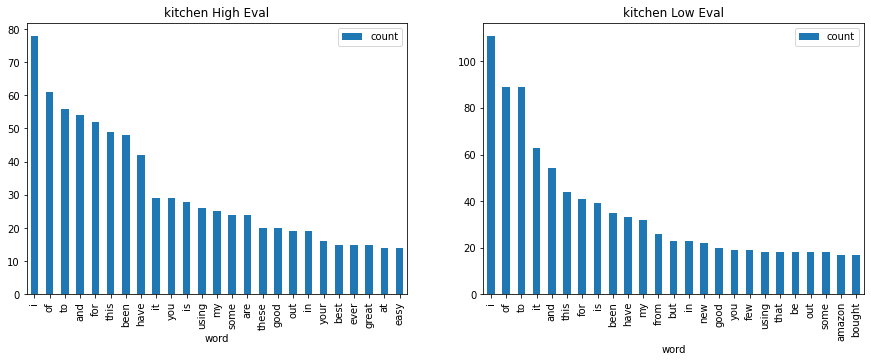

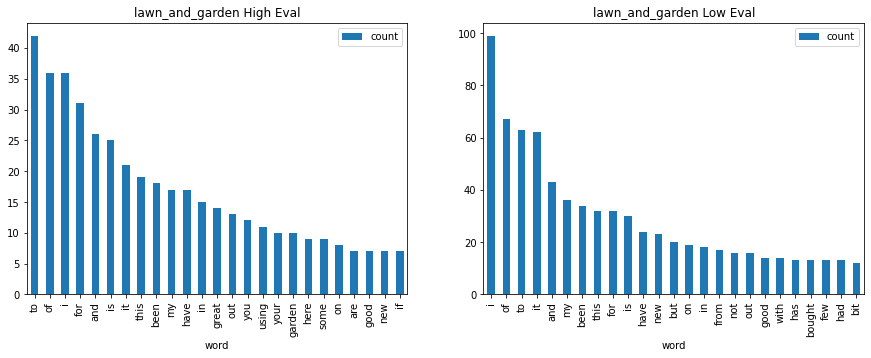

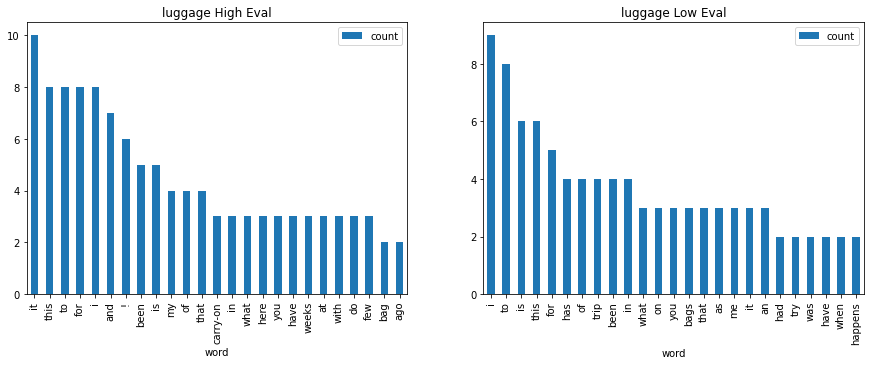

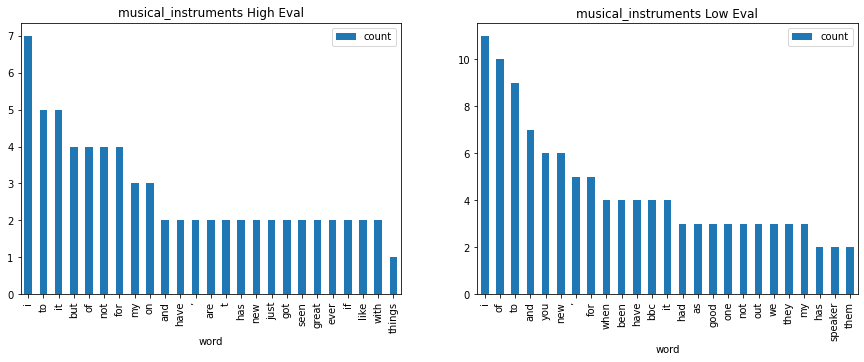

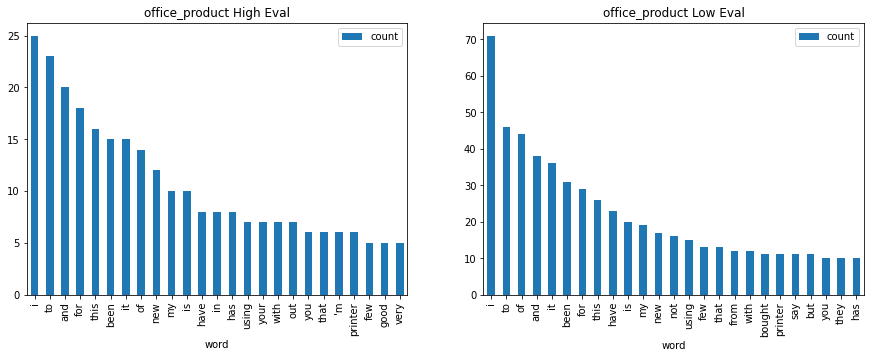

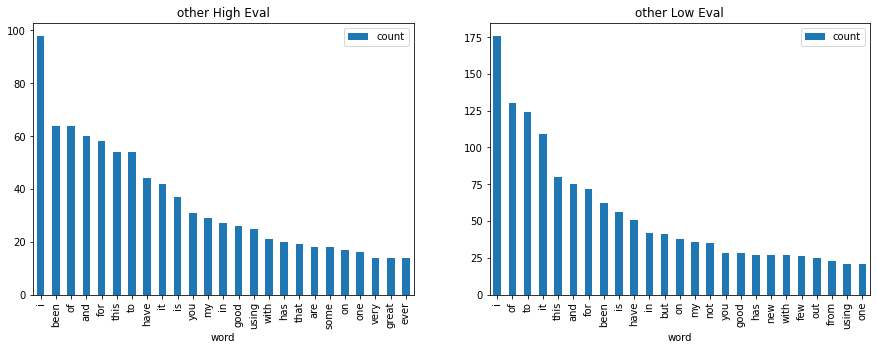

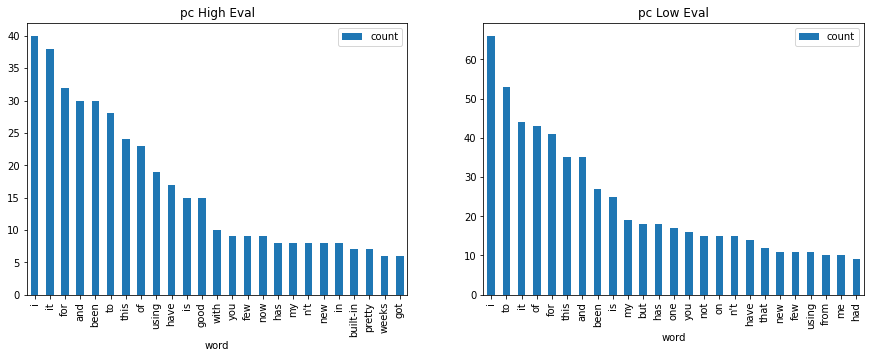

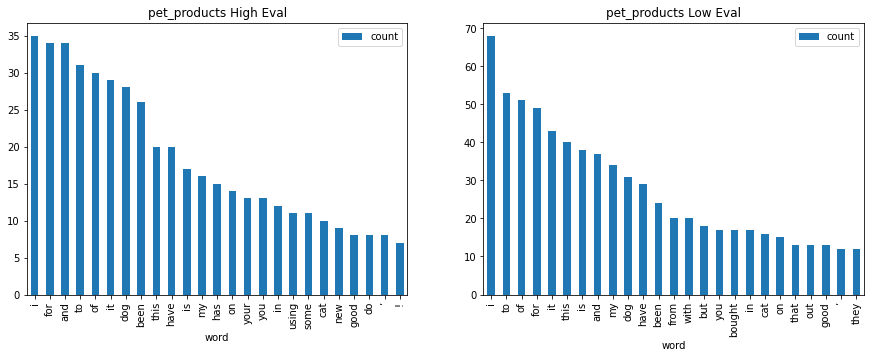

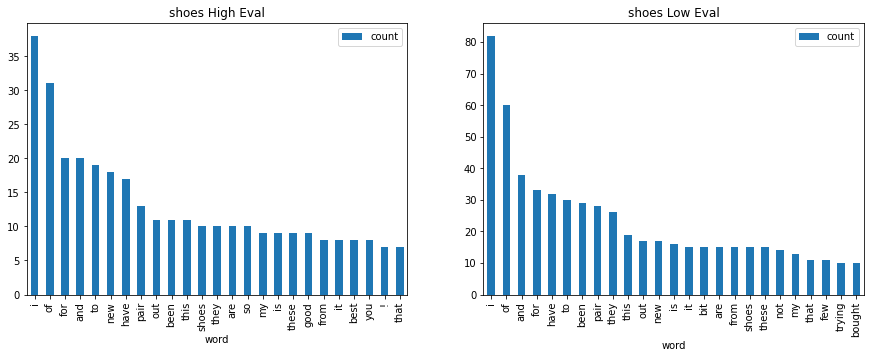

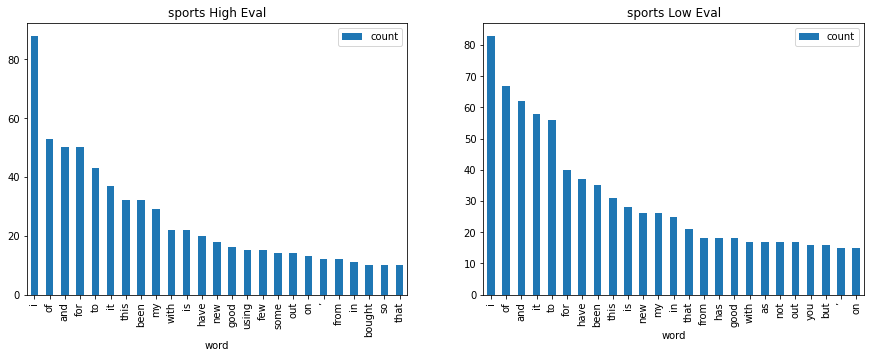

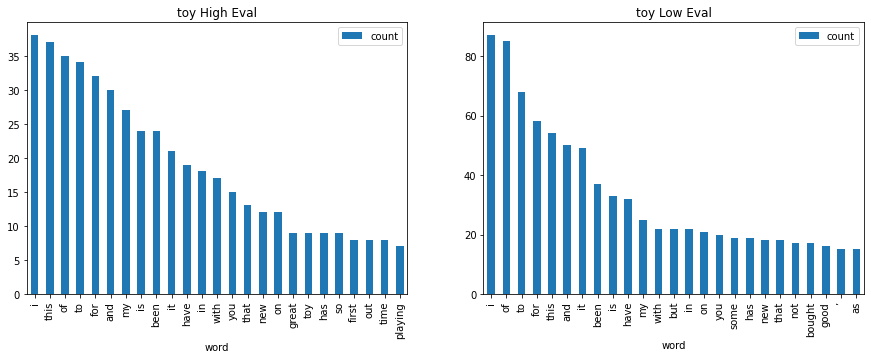

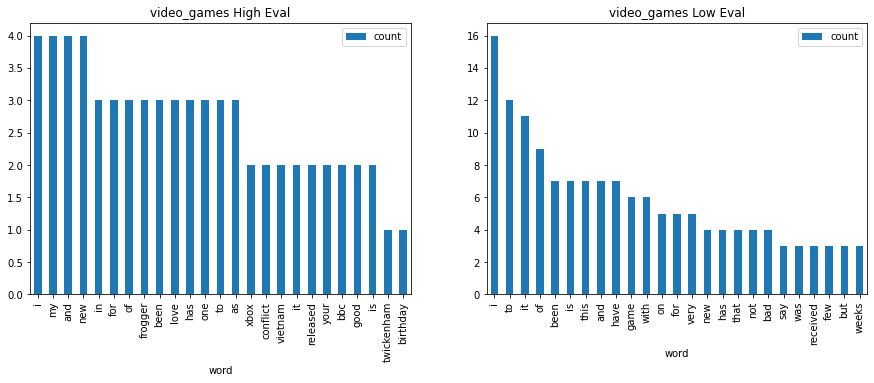

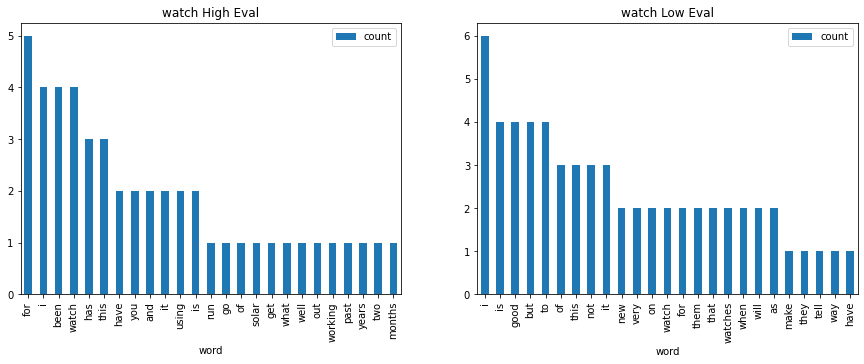

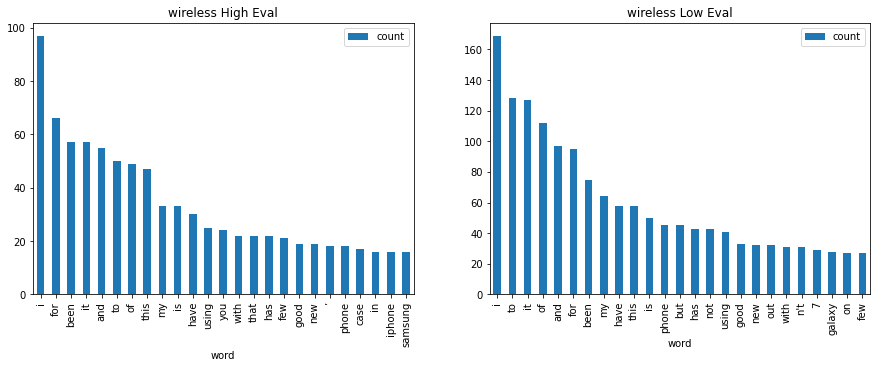

In [6]:
grouped_datasets = datasets.groupby('product_category')
for g_name, group_items in grouped_datasets:
    h_frequency = {}
    l_frequency = {}
    for summary, eval in zip(group_items['summary'], group_items['eval']):
        token = nltk.word_tokenize(summary)
        for w in token:
            lw = w.lower()
            if lw in ('.', ',', '\'ve', '\'s', 'a', 'the'):
                continue
            if eval == 'H':
                if h_frequency.get(lw):
                    h_frequency[lw] += 1
                else:
                    h_frequency[lw] = 1
            else:
                if l_frequency.get(lw):
                    l_frequency[lw] += 1
                else:
                    l_frequency[lw] = 1
    h_word_count = pd.DataFrame(list(h_frequency.items()), columns=['word', 'count'], dtype=float)
    l_word_count = pd.DataFrame(list(l_frequency.items()), columns=['word', 'count'], dtype=float)
    if len(h_word_count.index) == 0 or len(l_word_count.index) == 0:
        print(f'The length of the {g_name} data was 0 and skipped.')
        continue
    

    h_word_ranked = h_word_count.sort_values('count', ascending=False)[:25].reset_index()
    l_word_ranked = l_word_count.sort_values('count', ascending=False)[:25].reset_index()
    fig, axes = plt.subplots(nrows=1, ncols=2, squeeze=False)
    h_word_ranked.plot(title=f'{g_name} High Eval', kind="bar", x="word", y="count", ax=axes[0,0], figsize=(15, 5))
    l_word_ranked.plot(title=f'{g_name} Low Eval', kind="bar", x="word", y="count", ax=axes[0,1], figsize=(15, 5))
    # h_word_ranked.plot.bar(x='word', y='count', title=f'{g_name} High Eval')
    # l_word_ranked.plot.bar(x='word', y='count', title=f'{g_name} Low Eval')
    # h_word_ranked.to_csv(f'/content/drive/My Drive/Colab Notebooks/AITraining/csv/h_{g_name}.csv')
    # l_word_ranked.to_csv(f'/content/drive/My Drive/Colab Notebooks/AITraining/csv/l_{g_name}.csv')